In [1]:
#packages

#import python packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import peak_widths
import peakutils

In [2]:
#assigning filename handles to filenames

#assign filename variable
#example input: 2018_08_22_Myometrial_Contractility_Study_4_MB_1_8.tsv
filename = input("Input filename:" )
#assign variable for excel reference file
ref_filename = "./Myometrial Contractility Reference.txt"
#assign variable for comments file
comments_filename = filename[0:-4] + "_comments" + ".txt"

Input filename:2018_08_22_Myometrial_Contractility_Study_4_MB_1_8.tsv


In [3]:
#importing files and processing

#import muscle bath tsv file
df_file = pd.read_csv(filename, sep='\t')
#import data from excel reference file
df_ref = pd.read_csv(ref_filename, sep='\t')
#import corresponding comments file
comments_file = open(comments_filename,'r')
#process comments
cment_time = []
cment_txt = []
for line in comments_file:
    line = line.rstrip()
    line = line.split(sep = '\t')
    cment_time.append(line[0])
    cment_txt.append(line[1])
#drop unneccessary columns from muscle bath force file
df_file = df_file.drop(columns=['Timestamp','Stimulus'])
#set experiment time as index
df_file.set_index('Experiment Time', inplace = True)
#find filename in reference dataframe
df_ref = df_ref[df_ref['Filename'] == filename]
#drop extra columns
df_ref = df_ref[df_ref.columns[0:14]]
#check to see if muscle bundle should be excluded
df_ref = df_ref[df_ref["EXCLUDE SAMPLE"] != 1]
#reset df_ref index, starting at 0
#this enables easier indexing
df_ref.set_index([pd.Index(list(range(len(df_ref))))])

,Filename,Study,Patient,Bath Number,Patient Status,Pitocin,Amount (ml),Treatment,Conc. (ng/ml),Length (mm),Width1(mm),Width2(mm),Mass (mg),EXCLUDE SAMPLE
0,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,1,NaN,1.0,0.05,Adiponectin,100.0,28.21,1.78,2.00,100.0,NaN
1,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,2,NaN,0.0,0.00,TNF_alpha,10.0,22.77,1.99,2.84,100.0,NaN
2,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,3,NaN,1.0,0.05,Control,NaN,23.82,1.98,1.68,46.0,NaN
3,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,4,NaN,0.0,0.00,Adiponectin,100.0,32.81,2.98,1.65,130.0,NaN
4,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,5,NaN,1.0,0.05,TNF_alpha,10.0,25.07,3.16,1.68,108.0,NaN
5,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,6,NaN,0.0,0.00,Control,NaN,24.31,1.72,2.53,85.0,NaN
6,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,7,NaN,1.0,0.05,Adiponectin,100.0,28.13,2.77,1.31,66.0,NaN
7,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,8,NaN,0.0,0.00,TNF_alpha,10.0,28.24,1.73,1.68,72.0,NaN


In [4]:
#Determining when baseline ends and treatment begins

#print comments with timepoints
for counter, value in enumerate(cment_time):
    print(cment_txt[counter],":",value)
#create a list of the column names where muscle bath force values are stored
Force_list = ["Force1","Force2","Force3","Force4","Force5","Force6","Force7","Force8"]
#create a placeholder list for storing arrays of force data
baseline_array_list = []
#loop through viable muscle baths in study file (df_file) and retrieve baseline force data
#send array of each muscle bath baseline force data to baseline_array_list
#also create a placeholder list for treatment starttime to be later used in treatment peak analysis
treat_time_list = []
count = 0
for bath in df_ref['Bath Number']:
    print('Muscle Bath',bath,':')
    baseline_endtime = int(input("What time is treatment added?"))
    baseline_array = (df_file.loc[baseline_endtime-3599:baseline_endtime,Force_list[count]])
    baseline_array_list.append(baseline_array)
    treat_time_list.append(baseline_endtime)
    count += 1

Pitocin Bath 1 : 7379.6
Pitocin Bath 3 : 7420.3
Pitocin Bath 5 : 7446.4
Pitocin Bath 7 : 7472.4
Baseline : 11816.6
Treatment Bath 1 : 15489.1
Treatment Bath 2 : 15550.0
Treatment Bath 5 : 15639.5
Treatment Bath 7 : 15712.7
Treatment Bath 8 : 15754.7
Muscle Bath 1 :
What time is treatment added?15489
Muscle Bath 2 :
What time is treatment added?15550
Muscle Bath 3 :
What time is treatment added?15600
Muscle Bath 4 :
What time is treatment added?15600
Muscle Bath 5 :
What time is treatment added?15639
Muscle Bath 6 :
What time is treatment added?15700
Muscle Bath 7 :
What time is treatment added?15712
Muscle Bath 8 :
What time is treatment added?15754


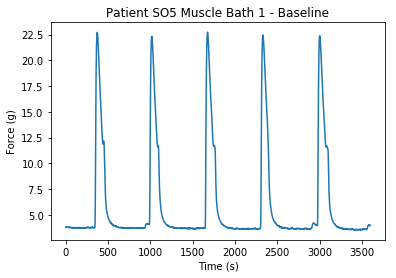

patientSO5_bath1_baseline.pdf


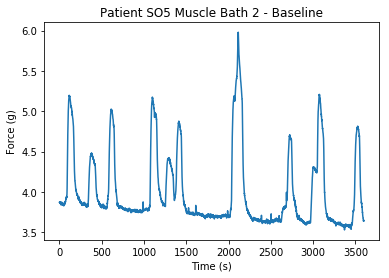

patientSO5_bath2_baseline.pdf


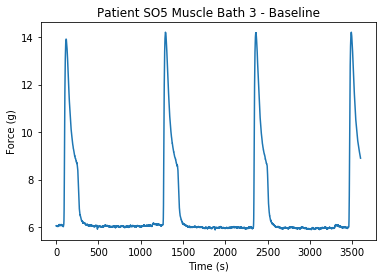

patientSO5_bath3_baseline.pdf


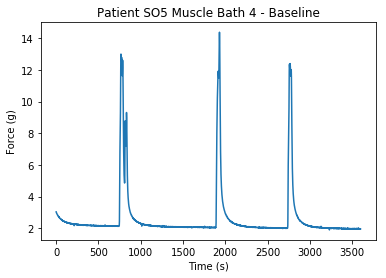

patientSO5_bath4_baseline.pdf


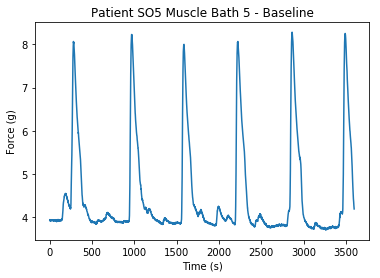

patientSO5_bath5_baseline.pdf


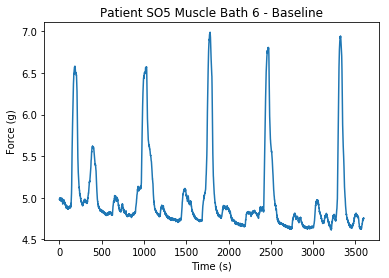

patientSO5_bath6_baseline.pdf


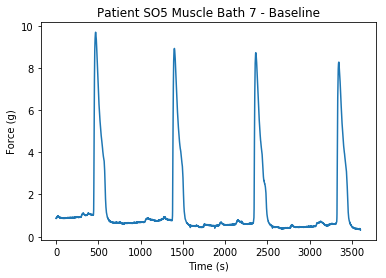

patientSO5_bath7_baseline.pdf


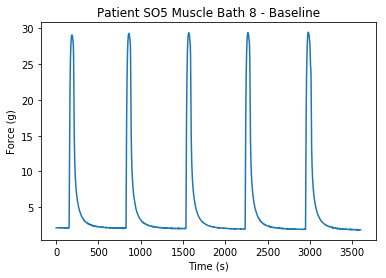

patientSO5_bath8_baseline.pdf


In [5]:
#Graphs for 1 hour baseline

#plot the baseline contraction force data from
#for bath in df_ref['Bath Number']:
for i in range(len(baseline_array_list)):        
    bath = df_ref.iloc[i]["Bath Number"]
    #print("Muscle Bath",bath)
    f = plt.figure()
    plt.plot(np.array(baseline_array_list[i]))
    plt.title("Patient "+list(df_ref['Patient'])[i]+" Muscle Bath "+str(bath)+" - Baseline")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    plt.show()
    #save baseline plots as pdf file
    savestring = "patient"+(list(df_ref['Patient'])[i])+"_"+"bath"+str(bath)+"_baseline"+'.pdf'
    print(savestring)
    f.savefig(savestring,sep = '')

In [29]:
#loop through muscle baths in reference dataframe 
    #for each bath listed in the reference file, find the local max 
    #for the 1 hr of baseline in the muscle bath file
    #ask when baseline ended for each bath and count backwords 1hr
#create storage lists for outputs
locmax_list = []
fp_output_list = []
#for loop for peak analysis
#vary width variable for each study to tune the find_peaks function
width_var = float(input("input the width variable for find_peaks function:"))
for i in range(len(baseline_array_list)):           
    bath = df_ref.iloc[i]["Bath Number"]
    print("Muscle Bath",bath,":")
    #input the height cut off for peak analysis
    cutoff = float(input("input peak height cutoff:"))
    #vary width variable for each study to tune the find_peaks function
    #comment out width_var unless need to vary width for each bath
    #width_var = float(input("input the width variable for find_peaks function:"))
    fp_output = find_peaks(np.array(baseline_array_list[(i)]),height = cutoff, width = width_var)
    locmax = np.array(baseline_array_list[(i)])[fp_output[0]]
    locmax_list.append(locmax)
    fp_output_list.append(fp_output)
#width variable used for analysis of each study:    
#width_var = 8 for 2018_09_28_Myometrial_Contractility_Study_13_MB_1_8.tsv
#width_var = 35 for 2018_12_07_Myometrial_Contractility_Study_14_a.tsv
#width_var = 35 for 2018_12_13_Myometrial_Contractility_Study_15_MBa.tsv
#width_var = 40 for 2018_12_17_Myometrial_Contractility_Study_16_MBa.tsv
#width_var = 25 for 2019_01_28_Myometrial_Contractility_Study_17_MBa.tsv

input the width variable for find_peaks function:25
Muscle Bath 1 :
input peak height cutoff:15
Muscle Bath 2 :
input peak height cutoff:4.6
Muscle Bath 3 :
input peak height cutoff:10
Muscle Bath 4 :
input peak height cutoff:11
Muscle Bath 5 :
input peak height cutoff:7
Muscle Bath 6 :
input peak height cutoff:6
Muscle Bath 7 :
input peak height cutoff:6
Muscle Bath 8 :
input peak height cutoff:20


In [30]:
#processing find_peaks output
#assigning values from find peaks output to a list of local max indices 
locmax_indx_list = []
for i in range(len(fp_output_list)):
    locmax_indx_list.append(fp_output_list[i][0])
#assigning values from find peaks dictionary ouput to a list (to later be used with calculating duration of contractions, relaxation time, etc.)
locmax_dic_list = []
for i in range(len(fp_output_list)):
    locmax_dic_list.append(fp_output_list[i][1])

Muscle Bath 1


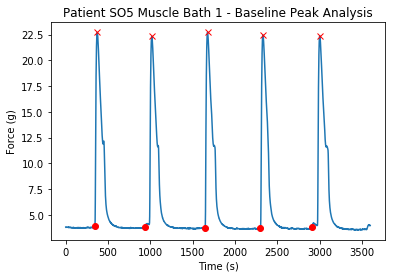

saved as: peakanalysisgraph_patientSO5_bath1_baseline.pdf
contraction baseline forces: [3.859 3.846 3.72  3.743 3.757]
Muscle Bath 2


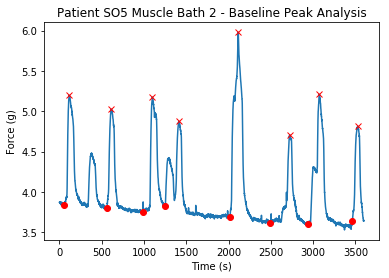

saved as: peakanalysisgraph_patientSO5_bath2_baseline.pdf
contraction baseline forces: [3.833 3.801 3.756 3.82  3.687 3.613 3.604 3.637]
Muscle Bath 3


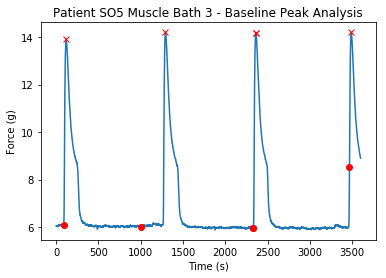

saved as: peakanalysisgraph_patientSO5_bath3_baseline.pdf
contraction baseline forces: [6.074 5.992 5.972 5.972 8.526]
Muscle Bath 4


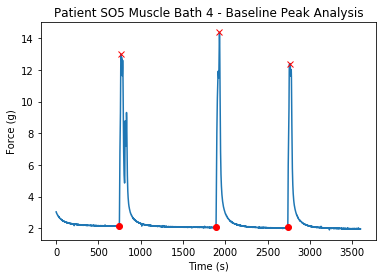

saved as: peakanalysisgraph_patientSO5_bath4_baseline.pdf
contraction baseline forces: [2.158 2.068 2.08 ]
Muscle Bath 5


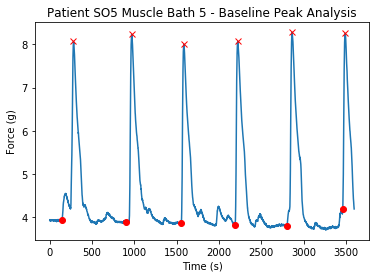

saved as: peakanalysisgraph_patientSO5_bath5_baseline.pdf
contraction baseline forces: [3.937 3.889 3.873 3.832 3.803 4.199]
Muscle Bath 6


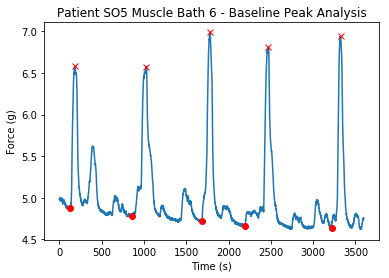

saved as: peakanalysisgraph_patientSO5_bath6_baseline.pdf
contraction baseline forces: [4.88  4.778 4.725 4.667 4.634]
Muscle Bath 7


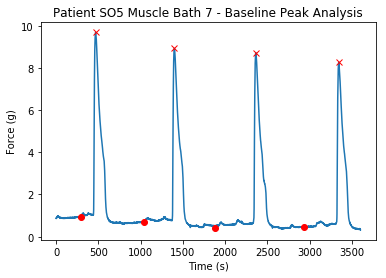

saved as: peakanalysisgraph_patientSO5_bath7_baseline.pdf
contraction baseline forces: [0.9445 0.6859 0.4018 0.439 ]
Muscle Bath 8


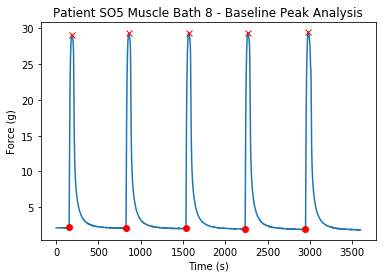

saved as: peakanalysisgraph_patientSO5_bath8_baseline.pdf
contraction baseline forces: [2.24  2.14  2.066 1.98  1.936]


In [44]:
#contraction baseline force determination, peak analysis graphs

#create list for contraction baseline forces
base = []
#loop through muscle baths 
for mb in range(len(df_ref)):
    #determine bath number
    bath = df_ref.iloc[mb]["Bath Number"]
    print("Muscle Bath",bath)
    #create figure to plot on
    f = plt.figure()
    #plot baseline force data for each muscle bath
    plt.plot(np.array(baseline_array_list[mb]))
    #label plot
    plt.title("Patient "+list(df_ref['Patient'])[x]+" Muscle Bath "+str(bath)+" - Baseline Peak Analysis")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    #use peak_widths function to determine the widths of contractions
    widths = peak_widths(baseline_array_list[mb],locmax_indx_list[mb],0.99)
    #create storage list for contraction baseline force
    storagelist = []
    #loop through each contraction, use info stored in widths variable
    #from the peak_widths function to determine the left baseline force 
    for contract_num in range(len(locmax_indx_list[mb])):
        #determine left baseline indx
        left_basex = int(widths[2][contract_num])
        #determine left baseline force
        left_basey = np.array(baseline_array_list[mb])[left_basex]
        #plot left baseline force on plot
        plt.plot(left_basex,left_basey,'ro')
        #store this muscle baths contraction baseline forces
        storagelist.append(left_basey)
    #loop through contraction peaks and plot the maximum
    for counter, peak in enumerate(locmax_list[mb]):
        plt.plot(locmax_indx_list[mb][counter],peak,'rx')
    plt.show()
    #save plots as pdf
    savestring = "peakanalysisgraph_" + "patient"+(list(df_ref['Patient'])[x])+"_"+"bath"+str(bath)+"_baseline"+'.pdf'
    print("saved as:",savestring)
    f.savefig(savestring,sep = '')
    #store contraction baseline forces
    base.append(np.array(storagelist))
    print("contraction baseline forces:",base[mb])
    

In [49]:
#baseline peak force calculations

#create an empty list to store raw forces and titles
raw_force_list = []
forcetitles = []
#calculate baseline peak forces
for x in range(len(locmax_list)):
    #create a temporary list to store values for each muscle bath
    templist = []
    bath = df_ref.iloc[x]["Bath Number"]
    title = "bath" + str(bath) +" force (g)"
    forcetitles.append(title)
    for contract in range(len(locmax_list[x])):
        amp = (locmax_list[x][contract]-base[x][contract])
        templist.append(amp)
    raw_force_list.append(np.array(templist))
#make a dictionary out of titles and raw forces    
rawforcedic = dict(zip(forcetitles, raw_force_list))
#for each muscle bath calculate the average raw peak value during baseline
#this will be used for treatment peak normalization
#create empty storage lists 
basepeakmean = []
#for loop calculation 
for bath in range(len(raw_force_list)):
    basepeakmean.append(raw_force_list[bath].mean())  
#calculate cross-sectional area (CSA)
CSA_list = []
for bath in df_ref['Bath Number']:
    length = float(df_ref[df_ref['Bath Number']== bath]['Length (mm)'])
    mass = float(df_ref[df_ref['Bath Number']== bath]['Mass (mg)'])
    CSA = (length *1.056)/mass
    CSA_list.append(CSA)
#create an empty list to store raw forces and titles
norm_force_list = []
normtitles = []
#calculate CSA normalized baseline peak forces
for x in range(len(locmax_list)):
    #create a temporary list to store values for each muscle bath
    templist = []
    bath = df_ref.iloc[x]["Bath Number"]
    title = "bath" + str(bath) +" norm (g/CSA)"
    normtitles.append(title)
    for contraction in range(len(locmax_list[x])):
        norm = ((locmax_list[x][contraction]-base[x][contraction])/CSA_list[x])
        templist.append(norm)
    norm_force_list.append(np.array(templist))
#make a dictionary out of titles and raw forces    
normforcedic = dict(zip(normtitles, norm_force_list))
#calculate mean NORMALIZED force for each muscle bath and standard deviation
#may not be useful
#standard deviation may say something about stability of recovery
#create empty storage lists 
CSAmean = []
CSAstd = []
#for loop calculation
counter = 0    
for bath in df_ref['Bath Number']:
    CSAmean.append(norm_force_list[counter].mean())
    CSAstd.append(norm_force_list[counter].std())
    counter+=1

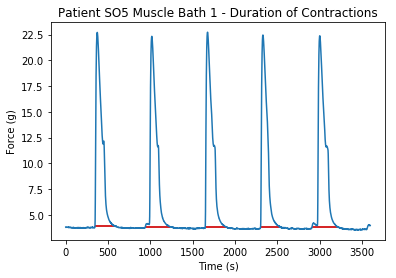

saved as: contractduration_patientSO5_bath1_baseline.pdf


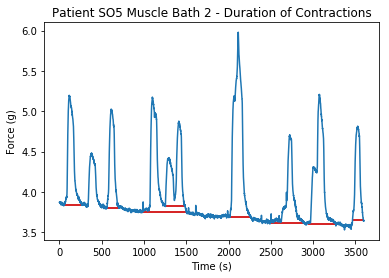

saved as: contractduration_patientSO5_bath2_baseline.pdf


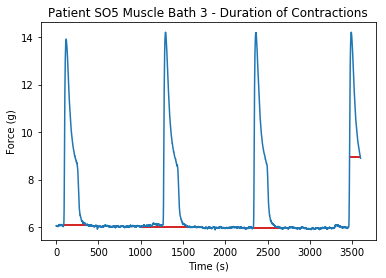

saved as: contractduration_patientSO5_bath3_baseline.pdf


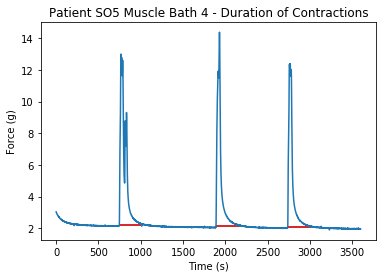

saved as: contractduration_patientSO5_bath4_baseline.pdf


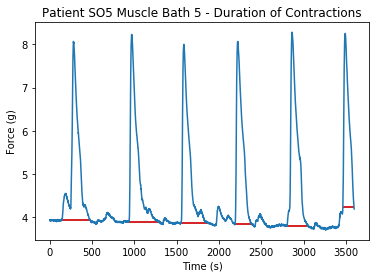

saved as: contractduration_patientSO5_bath5_baseline.pdf


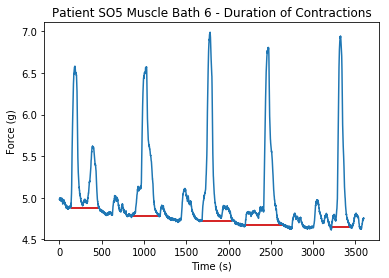

saved as: contractduration_patientSO5_bath6_baseline.pdf


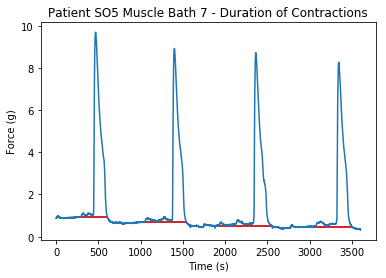

saved as: contractduration_patientSO5_bath7_baseline.pdf


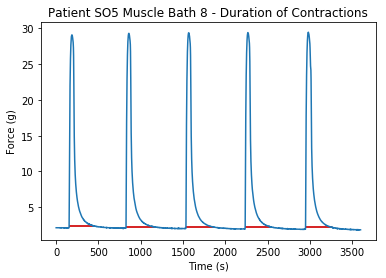

saved as: contractduration_patientSO5_bath8_baseline.pdf


In [118]:
#calculate duration of contractions
peakduration = []
base_duration_titles = []
for mb in range(len(baseline_array_list)):
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" duration times (s)"
    base_duration_titles.append(title)
    templist = []
    #create figure to plot on
    f = plt.figure()
    plt.plot(np.array(baseline_array_list[mb]))
    #label plot
    plt.title("Patient "+list(df_ref['Patient'])[mb]+" Muscle Bath "+str(bath)+" - Duration of Contractions")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    widths = peak_widths(baseline_array_list[mb],locmax_indx_list[mb],0.99)
    for contraction in range(len(locmax_list[mb])):
        leftx = ((widths[2][contraction]))
        rightx = ((widths[3][contraction]))
        templist.append(int(rightx-leftx))
        plt.hlines(*widths[1:], color="C3")
    plt.show()
    peakduration.append(np.array(templist))
    #save plots as pdf
    savestring = "contractduration_" + "patient"+(list(df_ref['Patient'])[mb])+"_"+"bath"+str(bath)+"_baseline"+'.pdf'
    print("saved as:",savestring)
    f.savefig(savestring,sep = '')
#make a dictionary for baseline contractions duration time    
base_contract_dur_time = dict(zip(base_duration_titles,peakduration))

In [119]:
#relaxation time
relaxtitle = []
relax_time = []
for mb in range(len(baseline_array_list)):
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" relaxation times (s)"
    relaxtitle.append(title)
    widths = peak_widths(baseline_array_list[mb],locmax_indx_list[mb],0.99)
    relax = widths[3]-locmax_indx_list[mb]
    relax = relax.astype(int)
    relax_time.append(relax)
#make a dictionary for baseline contractions duration time    
base_relax_time = dict(zip(relaxtitle,relax_time))

In [120]:
#sending baseline data to Excel spreadsheet

#create a dataframe to store raw force data
df_raw = pd.DataFrame.from_dict(rawforcedic, orient='index')
df_raw = df_raw.transpose()
#create a dataframe to store normalized data
df_norm = pd.DataFrame.from_dict(normforcedic, orient='index')
df_norm = df_norm.transpose()
#create a dataframe to store contraction duration time data
df_base_contract_dur = pd.DataFrame.from_dict(base_contract_dur_time, orient='index')
df_base_contract_dur = df_base_contract_dur.transpose()
#create a dataframe to store contraction relaxation time data
df_base_relax = pd.DataFrame.from_dict(base_relax_time, orient='index')
df_base_relax = df_base_relax.transpose()
#create output baseline dataframe
df_base_out = df_raw.join(df_norm)
df_base_out = df_base_out.join(df_base_contract_dur)
df_base_out = df_base_out.join(df_base_relax)
df_base_out.head()
#determine which set of muscle baths were used
if df_ref["Bath Number"].max() > 16:
    computer = "comp3"
elif df_ref["Bath Number"].max() < 9:
    computer = "comp1"
else: 
    computer = "comp2"
#write baseline dataframe to Excel spreadsheet
#assume tissue in set of 8 muscle baths comes from the 
#same patient 
base_out_file = "Patient"+ list(df_ref['Patient'])[0] +"_baseline_"+computer+".xlsx"
df_base_out.to_excel(base_out_file)
print(base_out_file)

PatientSO5_baseline_comp1.xlsx


In [ ]:
## 1 HOUR TREATMENT

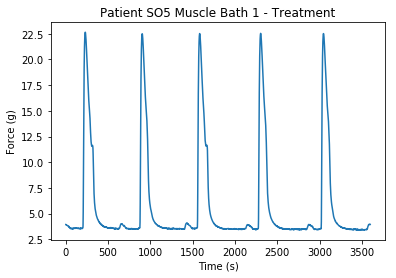

patientSO5_bath1_treatment.pdf


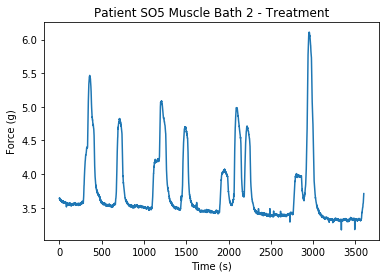

patientSO5_bath2_treatment.pdf


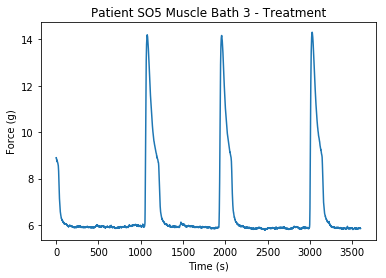

patientSO5_bath3_treatment.pdf


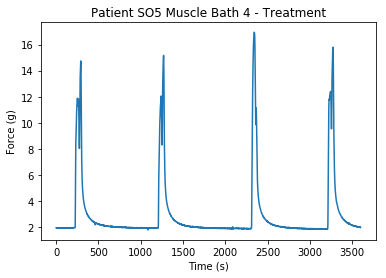

patientSO5_bath4_treatment.pdf


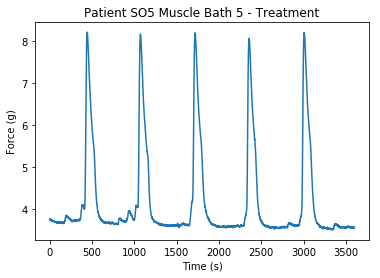

patientSO5_bath5_treatment.pdf


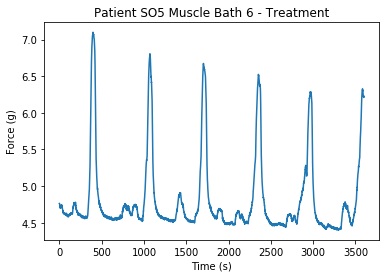

patientSO5_bath6_treatment.pdf


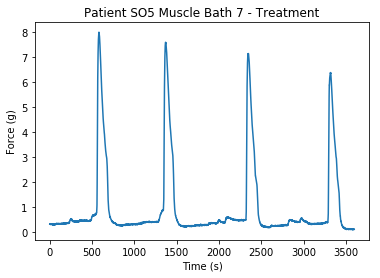

patientSO5_bath7_treatment.pdf


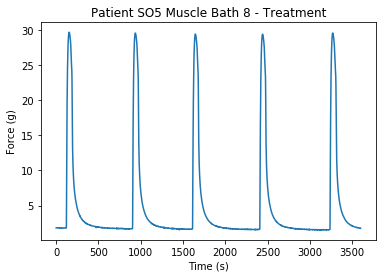

patientSO5_bath8_treatment.pdf


In [30]:
#create a placeholder list for storing arrays of treatment force data
treat_array_list = []
#loop through viable muscle baths in study file (df_file) and retrieve treatment force data
#send array of each muscle bath treatment force data to treat_array_list
count = 0
for bath in df_ref['Bath Number']:
    #print('Muscle Bath',bath,':')
    treatment_array = (df_file.loc[treat_time_list[count]:treat_time_list[count]+3599,Force_list[count]])
    treat_array_list.append(treatment_array)
    count += 1
#plot the treatment contraction force data
for i in range(len(treat_array_list)):        
    bath = df_ref.iloc[i]["Bath Number"]
    #print("Muscle Bath",bath)
    f = plt.figure()
    plt.plot(np.array(treat_array_list[i]))
    plt.title("Patient "+list(df_ref['Patient'])[i]+" Muscle Bath "+str(bath)+" - Treatment")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    plt.show()
    savestring = "patient"+(list(df_ref['Patient'])[i])+"_"+"bath"+str(bath)+"_treatment"+'.pdf'
    print(savestring)
    f.savefig(savestring,sep = '')

In [31]:
#peak analysis for 1 hour treatment
#create storage lists for outputs
treat_locmax_list = []
fp_treat_output_list = []
#for loop for peak analysis
#reuse the width variable defined earlier for baseline peak analysis
for i in range(len(treat_array_list)):           
    bath = df_ref.iloc[i]["Bath Number"]
    print("Muscle Bath",bath,":")
    #input the height cut off for peak analysis
    cutoff = float(input("input peak height cutoff:"))
    #vary width variable for each study to tune the find_peaks function
    #comment out width_var unless need to vary width for each bath
    #width_var = float(input("input the width variable for find_peaks function:"))
    fp_output = find_peaks(np.array(treat_array_list[(i)]),height = cutoff, width = width_var)
    locmax = np.array(treat_array_list[(i)])[fp_output[0]]
    treat_locmax_list.append(locmax)
    fp_treat_output_list.append(fp_output)
#width variable used for analysis of each study:    
#width_var = 8 for 2018_09_28_Myometrial_Contractility_Study_13_MB_1_8.tsv
#width_var = 35 for 2018_12_07_Myometrial_Contractility_Study_14_a.tsv
#width_var = 35 for 2018_12_13_Myometrial_Contractility_Study_15_MBa.tsv
#width_var = 40 for 2018_12_17_Myometrial_Contractility_Study_16_MBa.tsv
#width_var = 25 for 2019_01_28_Myometrial_Contractility_Study_17_MBa.tsv

Muscle Bath 1 :
input peak height cutoff:15
Muscle Bath 2 :
input peak height cutoff:4.3
Muscle Bath 3 :
input peak height cutoff:10
Muscle Bath 4 :
input peak height cutoff:10
Muscle Bath 5 :
input peak height cutoff:6
Muscle Bath 6 :
input peak height cutoff:6
Muscle Bath 7 :
input peak height cutoff:4
Muscle Bath 8 :
input peak height cutoff:15


In [42]:
#processing find_peaks output
#assigning values from find peaks output to a list of local max indices 
locmax_indx_treat_list = []
for i in range(len(fp_treat_output_list)):
    locmax_indx_treat_list.append(fp_treat_output_list[i][0])
#assigning values from find peaks dictionary ouput to a list (to later be used with calculating duration of contractions, relaxation time, etc.)
locmax_dic_treat_list = []
for i in range(len(fp_treat_output_list)):
    locmax_dic_treat_list.append(fp_treat_output_list[i][1])

How long (sec) before a peak should the local min baseline begin?600
Duration (sec) of local min baseline:550
Muscle Bath 1


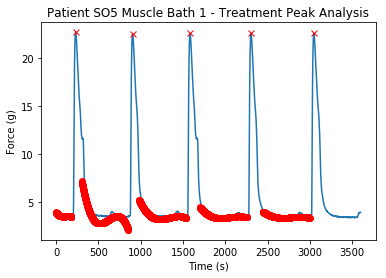

peakanalysisgraphs_patientSO5_bath1_treatment.pdf
mean baseline force: [3.59761394 3.53791617 3.61726372 3.5669118  3.50686704]
Muscle Bath 2


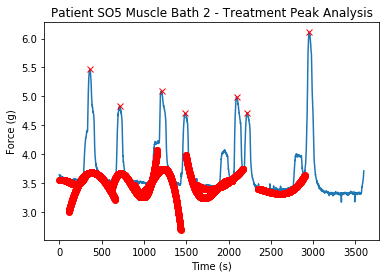

peakanalysisgraphs_patientSO5_bath2_treatment.pdf
mean baseline force: [3.52528919 3.49165242 3.4967036  3.47445029 3.43428886 3.48740365
 3.3827182 ]
Muscle Bath 3


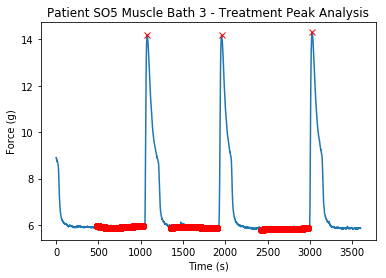

peakanalysisgraphs_patientSO5_bath3_treatment.pdf
mean baseline force: [5.91044518 5.89757206 5.83763888]
Muscle Bath 4


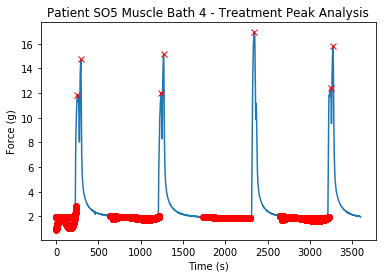

peakanalysisgraphs_patientSO5_bath4_treatment.pdf
mean baseline force: [1.9288236  1.55602854 1.9293217  1.85418214 1.8990868  1.90266022
 1.78252204]
Muscle Bath 5


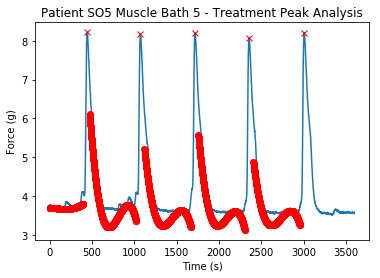

peakanalysisgraphs_patientSO5_bath5_treatment.pdf
mean baseline force: [3.69642498 3.75438114 3.60554267 3.64247957 3.56477039]
Muscle Bath 6


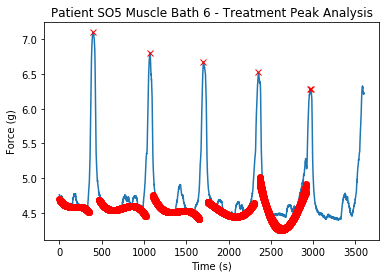

peakanalysisgraphs_patientSO5_bath6_treatment.pdf
mean baseline force: [4.59513962 4.57125286 4.53880549 4.52124786 4.47793745 4.48681341]
Muscle Bath 7


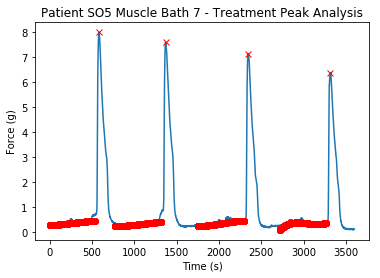

peakanalysisgraphs_patientSO5_bath7_treatment.pdf
mean baseline force: [0.36141302 0.31133014 0.34403471 0.32380317]
Muscle Bath 8


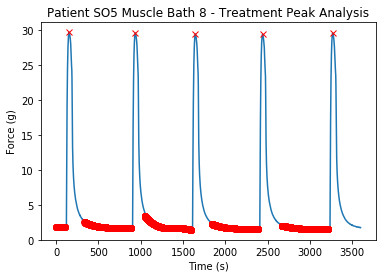

peakanalysisgraphs_patientSO5_bath8_treatment.pdf
mean baseline force: [1.81221525 1.88879886 1.94875534 1.74421238 1.67095633]


In [82]:
#find a baseline/local minima range before each peak
#create an empty list to store start indices
#startlist = []
#create an empty list to store end indices
#endlist = []
#create an empty list to store an arrays of baseline values
base_val_list = []
#create an empty list to temporarily store baseline means
templist = []
#create an empty list to append array of baseline means
base_treat = []
#





timebeforepeak = int(input("How long (sec) before a peak should the local min baseline begin?"))
baselineduration = int(input("Duration (sec) of local min baseline:"))
#loop through muscle baths
for x in range(len(df_ref)):
    bath = df_ref.iloc[x]["Bath Number"]
    #reset lists
    startlist = []
    endlist = []
    base_val_list = []
    templist = []
    print("Muscle Bath",bath)
    #loop through local max indices and calculate start point and end point for baseline calculation as an offset of this timepoint
    #store values in startlist and endlist
    for peak_time in locmax_indx_treat_list[x]:
        #vary start time and end time in order to find proper baseline local min
        starttime = peak_time - timebeforepeak
        endtime = starttime + baselineduration
        if starttime < 0:
            starttime = 0
        if endtime < 0:
            endtime = 2
        startlist.append(starttime)
        endlist.append(endtime)
        
    #loop through contractions, calculate baseline values, assign values to spot in base_val_list
    for i in range(len(startlist)):
        baseline_values = peakutils.baseline(np.array(treat_array_list[x])[startlist[i]:endlist[i]])
        base_val_list.append(baseline_values)
    #plot muscle baths with local min baseline and local max values highlighted     
    f = plt.figure()
    plt.plot(np.array(treat_array_list[x])) 
    plt.title("Patient "+list(df_ref['Patient'])[x]+" Muscle Bath "+str(bath)+" - Treatment Peak Analysis")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    for counter, base_data in enumerate(base_val_list):
        plt.plot(np.arange(startlist[counter],endlist[counter]),base_data,'ro')
    for counter, peak in enumerate(treat_locmax_list[x]):
        plt.plot(locmax_indx_treat_list[x][counter],peak,'rx')
    plt.show()
    
    savestring = "peakanalysisgraphs_" + "patient"+(list(df_ref['Patient'])[x])+"_"+"bath"+str(bath)+"_treatment"+'.pdf'
    print(savestring)
    f.savefig(savestring,sep = '')
    #average local min baseline data
    for base_val in base_val_list:
        #altered code to calculate the minimum value of baseline instead of average*******
        templist.append(base_val.mean())
        #templist.append(base_val.min())
        base_mean_array = np.array(templist)
    print("mean baseline force:",base_mean_array)
    #store local min baseline data in list
    base_treat.append(base_mean_array)

In [85]:
#treatment peak force calculations
#create an empty list to store the raw treatment peak values
treatpeakvals = []
treatpeaktitles = []
#calculate treatment peak forces
for mb in range(len(treat_locmax_list)):
    #create a temporary list to store each contraction peak for current muscle bath
    templist = []
    for contraction in range(len(treat_locmax_list[mb])):
        amplitude = (treat_locmax_list[mb][contraction]-base_treat[mb][contraction])
        templist.append(amplitude)
    treatpeakvals.append(np.array(templist))
    #create a title for these values. store them in a list 
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" force (g)"
    treatpeaktitles.append(title)
#normalizing to baseline function
#create an empty list to store the normalized treatment peak values and titles
normalized_treatment_peaks = []
normtreatpeaktitles = []
#normalize forces to baseline average peak force
for mb in range(len(treatpeakvals)):
    peaks_norm_2_base_function = treatpeakvals[mb]/basepeakmean[mb]
    normalized_treatment_peaks.append(peaks_norm_2_base_function)
    #normalized treatment peaks titles (for column labels in Excel file)
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" normalized to baseline"
    normtreatpeaktitles.append(title)
#make a dictionary out of titles and raw treatment contraction peaks    
treatpeakdic = dict(zip(treatpeaktitles, treatpeakvals))
#make a dictionary out of tiles and normalized treatment contraction peaks
treatnormpeakdic = dict(zip(normtreatpeaktitles, normalized_treatment_peaks))



In [86]:
#export treatment peak data to Excel spreadsheet
#create a dataframe to store raw force data
df_t_raw = pd.DataFrame.from_dict(treatpeakdic, orient='index')
df_t_raw = df_t_raw.transpose()
#create a dataframe to store normalized data
df_t_norm = pd.DataFrame.from_dict(treatnormpeakdic, orient='index')
df_t_norm = df_t_norm.transpose()
#create output baseline dataframe
df_treat_out = df_t_raw.join(df_t_norm)
df_treat_out.head()
#determine which set of muscle baths were used
if df_ref["Bath Number"].max() > 16:
    computer = "comp3"
elif df_ref["Bath Number"].max() < 9:
    computer = "comp1"
else: 
    computer = "comp2"
#write baseline dataframe to Excel spreadsheet
#assume tissue in set of 8 muscle baths comes from the 
#same patient 
treat_out_file = "Patient"+ list(df_ref['Patient'])[0] +"_treatment_"+computer+".xlsx"
df_treat_out.to_excel(treat_out_file)
print(treat_out_file)


PatientSO5_treatment_comp1.xlsx


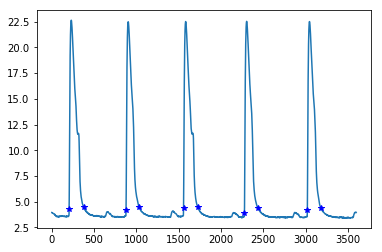

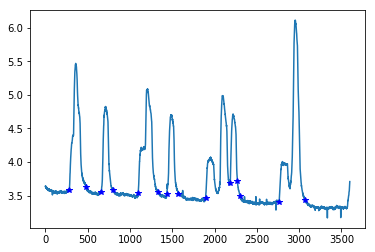

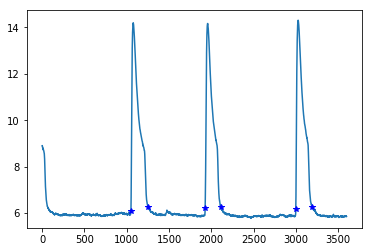

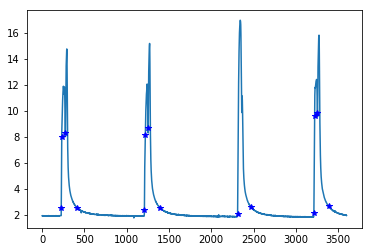

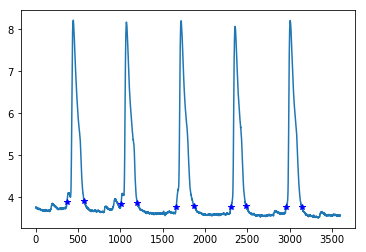

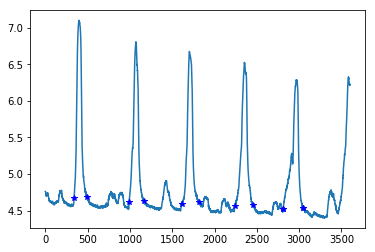

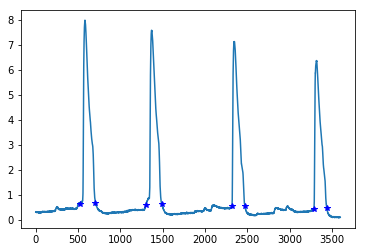

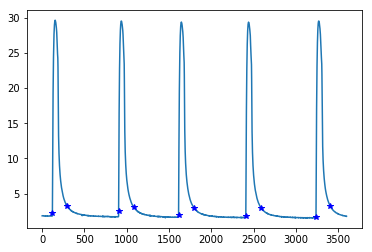

[array([170, 155, 167, 157, 159]), array([200, 136, 232, 135, 408,  84, 305]), array([200, 185, 196]), array([ 42, 189,  31, 188, 160,  33, 176]), array([205, 192, 208, 180, 182]), array([152, 170, 206, 215, 237, 237]), array([180, 189, 152, 149]), array([176, 177, 182, 180, 170])]


In [169]:
#calculate duration of contractions
peakduration = []
for mb in range(len(treat_array_list)):
    templist = []
    plt.plot(np.array(treat_array_list[mb]))
    widths = peak_widths(treat_array_list[mb],locmax_indx_treat_list[mb],0.95)
    for contraction in range(len(treat_locmax_list[mb])):
        leftx = (int(widths[2][contraction]))
        lefty = np.array(treat_array_list[mb])[leftx]
        plt.plot(leftx,lefty,'b*')
        rightx = (int(widths[3][contraction]))
        righty = np.array(treat_array_list[mb])[rightx]
        plt.plot(rightx,righty,'b*')
        templist.append(rightx-leftx)
    plt.show()
    peakduration.append(np.array(templist))

print(peakduration)

In [ ]:
#calculate relaxation time


In [229]:
#4 parameters
#1. peak force or amplitude
#2. frequency or contractions/hour
#3. duration of contractions
#4. relaxation time

In [230]:
comments_file.close()